In [1]:
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pathlib
import os
import folium
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm

In [2]:
file_location = 'E:/QGIS/gkpg'
district = '/berlin_district_population.gpkg'
cycle = '/cycle.gpkg'
district = gpd.read_file(file_location + district)
cycle = gpd.read_file(file_location + cycle)



In [3]:
# 1. Calculate district population density
district['area'] = district.geometry.area / 1000000  # area in sq km
district['pop_density'] = district['ew2022'] / district['area']

In [4]:
print(cycle.crs)

EPSG:25833


In [5]:
# Calculate the intersection of buffer with districts
# districts['cycling_area'] = districts.intersection(cycling_buffer.unary_union).area
# districts['cycling_coverage'] = districts['cycling_area'] / districts.geometry.area

In [6]:
# district.drop('area in sqkm', axis=1, inplace=True)

In [7]:
# 2. Analyze cycling network coverage
# Create a 500m buffer around the cycling network
cycle = cycle.to_crs(district.crs)
cycling_buffer = cycle.buffer(500).to_crs(district.crs)
cycling_buffer = gpd.GeoDataFrame(geometry=gpd.GeoSeries(cycling_buffer.unary_union))
cycling_buffer.crs = cycle.crs

In [8]:
print(cycling_buffer.crs)

EPSG:3857


In [9]:
# Calculate the intersection of buffer with districts
district['cycling_area'] = district.intersection(cycling_buffer.unary_union).area
district['cycling_coverage'] = district['cycling_area'] / district.geometry.area

In [10]:
district.head()

,district,ew2022,area,pop_density,geometry,cycling_area,cycling_coverage
0,Charlottenburg-Wilmersdorf,336511,174.273751,1930.933367,"POLYGON ((1470455.944 6892116.048, 1470473.976...",1.348409e+08,0.773730
1,Friedrichshain-Kreuzberg,281891,54.960475,5128.976793,"POLYGON ((1492196.828 6892490.507, 1492255.440...",5.400777e+07,0.982666
2,Lichtenberg,298630,140.620796,2123.654604,"POLYGON ((1499030.770 6895442.899, 1498969.922...",1.182911e+08,0.841206
3,Marzahn-Hellersdorf,282575,166.680347,1695.310849,"POLYGON ((1506953.269 6893272.078, 1506921.987...",1.491880e+08,0.895054
4,Mitte,378375,106.299293,3559.525087,"POLYGON ((1483404.726 6898781.795, 1483399.681...",1.040425e+08,0.978770


Text(0.5, 1.0, 'Population Density vs Cycling Network Coverage')

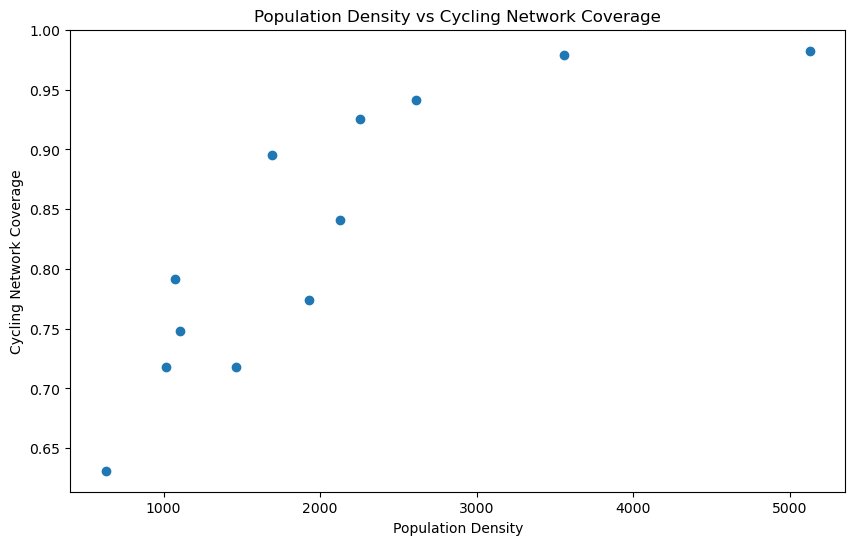

In [11]:
# 3. Identify mismatches
# Create a scatter plot

plt.figure(figsize=(10, 6))
plt.scatter(district['pop_density'], district['cycling_coverage'])
plt.xlabel('Population Density')
plt.ylabel('Cycling Network Coverage')
plt.title('Population Density vs Cycling Network Coverage')
# plt.savefig('density_vs_coverage_scatter.png')

In [12]:
# Identify districts with high density but low cycling coverage
threshold_density = district['pop_density'].median()
threshold_coverage = district['cycling_coverage'].median()
district['accessibility_gap'] = (district['pop_density'] > threshold_density) & (district['cycling_coverage'] < threshold_coverage)

In [30]:
district

,district,ew2022,area,pop_density,geometry,cycling_area,cycling_coverage,accessibility_gap
0,Charlottenburg-Wilmersdorf,336511,174.273751,1930.933367,"POLYGON ((1470455.944 6892116.048, 1470473.976...",1.348409e+08,0.773730,True
1,Friedrichshain-Kreuzberg,281891,54.960475,5128.976793,"POLYGON ((1492196.828 6892490.507, 1492255.440...",5.400777e+07,0.982666,False
2,Lichtenberg,298630,140.620796,2123.654604,"POLYGON ((1499030.770 6895442.899, 1498969.922...",1.182911e+08,0.841206,False
3,Marzahn-Hellersdorf,282575,166.680347,1695.310849,"POLYGON ((1506953.269 6893272.078, 1506921.987...",1.491880e+08,0.895054,False
4,Mitte,378375,106.299293,3559.525087,"POLYGON ((1483404.726 6898781.795, 1483399.681...",1.040425e+08,0.978770,False
5,Neukölln,314946,120.712130,2609.066709,"POLYGON ((1492423.228 6878128.665, 1492427.384...",1.136260e+08,0.941297,False
6,Pankow,407962,279.266412,1460.834468,"MULTIPOLYGON (((1490891.459 6917719.645, 14908...",2.004598e+08,0.717809,False
7,Reinickendorf,259406,241.658472,1073.440535,"POLYGON ((1470063.711 6909609.116, 1470031.099...",1.913398e+08,0.791778,False
8,Spandau,251720,247.776942,1015.913742,"POLYGON ((1462927.969 6889245.992, 1462936.751...",1.778381e+08,0.717735,False
9,Steglitz-Zehlendorf,304242,275.457169,1104.498390,"POLYGON ((1467326.197 6883662.022, 1467718.488...",2.059972e+08,0.747837,False


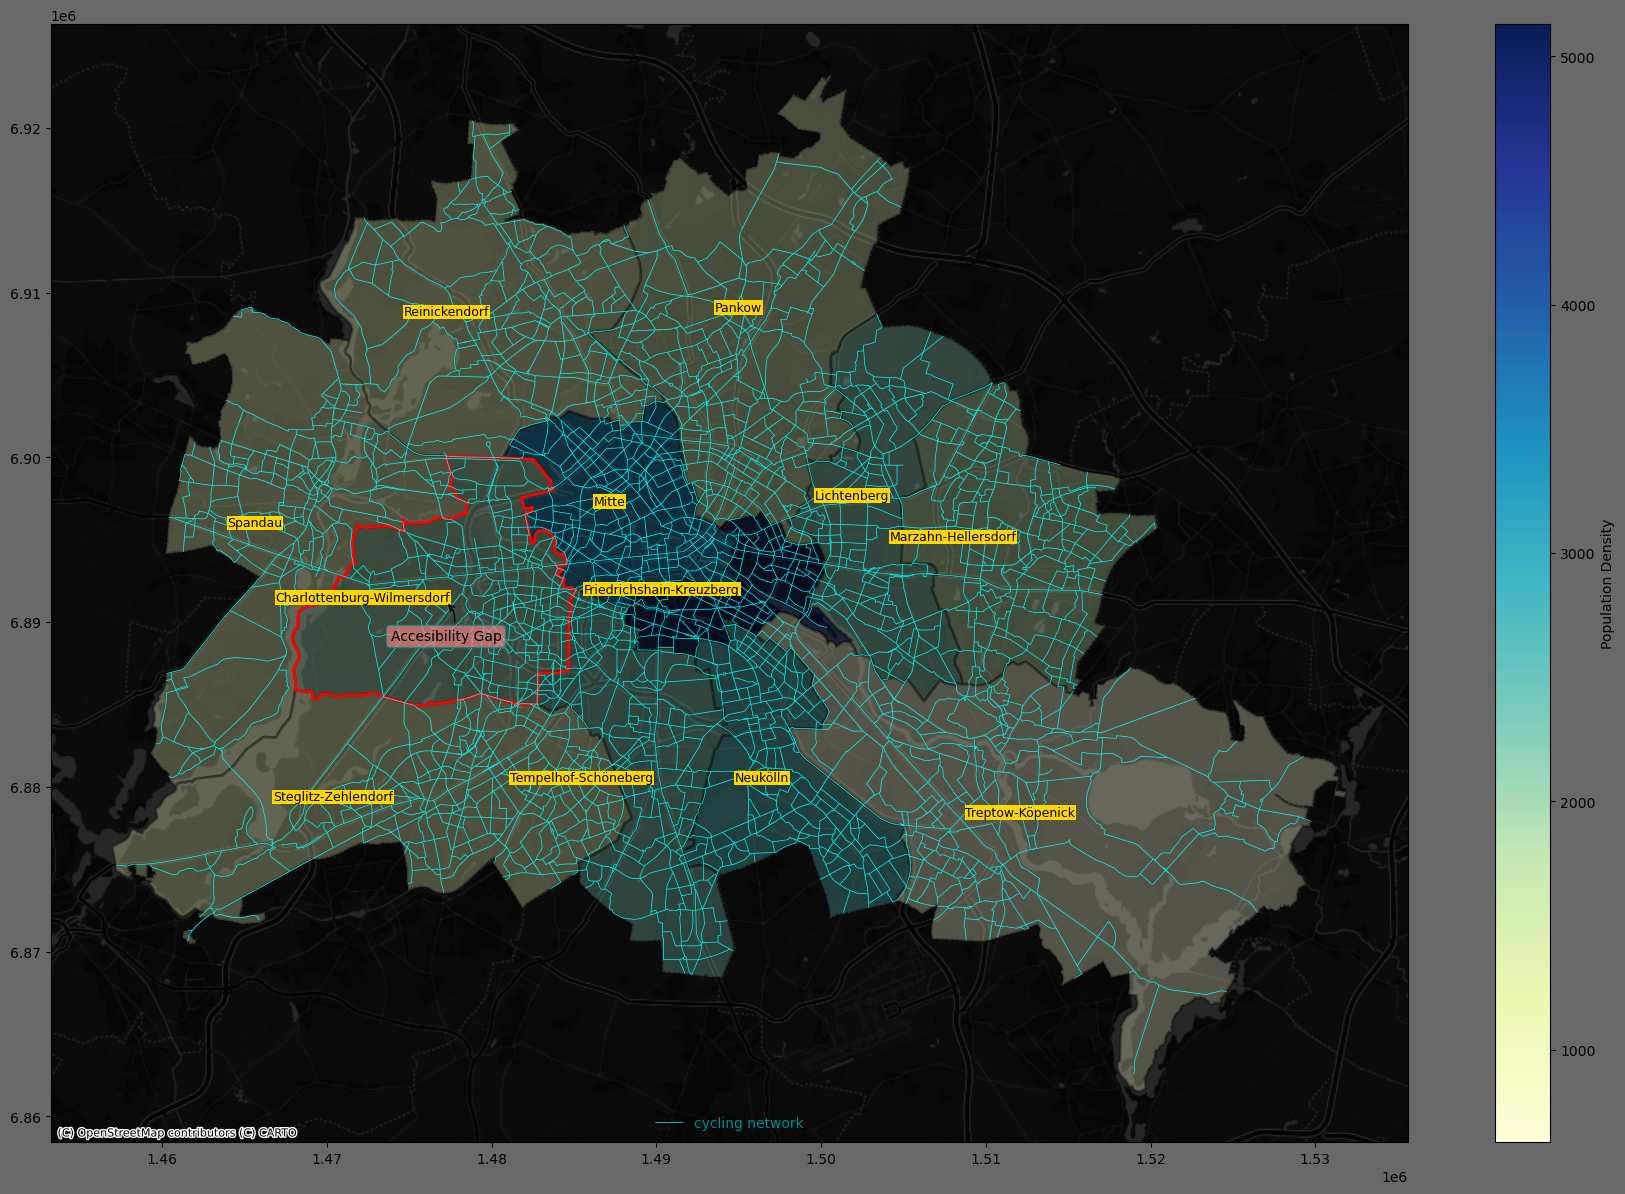

In [29]:
# 4. Create the map
fig, ax = plt.subplots(figsize=(18,12))

# Plot population density
district.plot(column='pop_density', ax=ax, legend=True, edgecolor='black', linewidth=2, legend_kwds={'label': 'Population Density'}, cmap='YlGnBu', alpha=0.3)


# Add district name labels

for idx, row in district.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['district'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                xytext=(3, 3), textcoords="offset points", ha='right', va='center', fontsize=9,
                bbox=dict(facecolor='gold', alpha=1, edgecolor='none', pad=0.5))

# Add "Gap" label
# Add district name labels and highlight acces,sibility gaps
    
     # Highlight districts with accessibility gap
    if row['accessibility_gap']:
        # Add a red circle annotation
        circle = Circle((centroid.x, centroid.y), 0.02, fill=False, 
                        edgecolor='red', linewidth=2, alpha=0.7)
        ax.add_patch(circle)
        ax.annotate("Accesibility Gap", xy=(centroid.x, centroid.y), xytext=(0, -20), 
                    textcoords="offset points", ha='center', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightcoral", ec="darkcyan", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.5"))
# Plot cycling network
cycle.plot(ax=ax, color='aqua', linewidth=0.5,  label ='cycling network')

legend = plt.legend(loc='lower center', facecolor = 'none', edgecolor ='none')

for text in legend.get_texts():
    text.set_color("darkcyan")  # Set font color to red

fig.patch.set_facecolor('dimgray')

# Set the axes background color to black
ax.set_facecolor('dimgray')
# Highlight districts with accessibility gap
district[district['accessibility_gap']].plot(ax=ax, color='none',
                                            edgecolor='red', linewidth=2)

# ax.axis('off')
# plt.title('Cycling Accessibility Gap of Berlin in High-Density Districts',  fontsize=15, color='darkcyan')
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels)

# saving the map
NOTEBOOK_PATH = pathlib.Path().resolve()
Map = NOTEBOOK_PATH / "../Map" 

figure_path = os.path.join(Map, "Berlin_cycling_network_&_pop.png")
plt.tight_layout()
plt.savefig(figure_path, dpi=300) #define the size